In [1]:
import os

# Check CPU information
cpu_info = !cat /proc/cpuinfo  # For Linux-based systems

# Print CPU information
for line in cpu_info:
    print(line)


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 66.7 MB/s eta 0:00:00


In [3]:
!pip install ucimlrepo

In [4]:
#update scikit - learn for precision
!pip install scikit-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Multiclass Margin Classifier

a quantum variation of SVM (uses multiclass margin loss function)

In [1]:
import pennylane as qml
import torch
import numpy as np
import pandas as pd
from torch.autograd import Variable
import torch.optim as optim
from sklearn.preprocessing import LabelBinarizer
import time
import matplotlib.pyplot as plt

#Iris dataset
from sklearn.datasets import load_iris

#Wine quality
from ucimlrepo import fetch_ucirepo

#import dataset from OpenML
from sklearn.datasets import fetch_openml

#dimensionality reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

#metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [2]:
#set seed and parameters
np.random.seed(0)
torch.manual_seed(0)

## Layer and Circuit

In [7]:
#layer
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        # Apply additional CNOT to entangle the last with the first qubit
        qml.CNOT(wires=[num_qubits - 1, 0])

In [8]:
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0.0, normalize=True)
    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [9]:
def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

## Loss function

In [10]:
#Loss function
def multiclass_svm_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        s_true = variational_classifier(
            q_circuits[int(true_labels[i])],
            (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
            feature_vec,
        )
        s_true = s_true.float()
        li = 0

        # Get the scores computed for this sample by the other classifiers
        for j in range(num_classes):
            if j != int(true_labels[i]):
                s_j = variational_classifier(
                    q_circuits[j], (all_params[0][j], all_params[1][j]), feature_vec
                )
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

## Classification function

In [11]:
#classification function
def classify(q_circuits, all_params, feature_vecs, labels):
    predicted_labels = []
    for i, feature_vec in enumerate(feature_vecs):
        scores = np.zeros(num_classes)
        for c in range(num_classes):
            score = variational_classifier(
                q_circuits[c], (all_params[0][c], all_params[1][c]), feature_vec
            )
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
    return predicted_labels

In [12]:
def accuracy(labels, hard_predictions):
    loss = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / labels.shape[0]
    return loss

## Data and preprocessing

In [13]:
def load_and_process_data(X,Y):
    X = torch.tensor(X)
    print("First X sample, original  :", X[0])

    # standartize each input
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)
    print("First X sample, normalized:", X_norm[0])

    Y = torch.tensor(Y)
    return X, Y


# Create a train and test split.
def split_data(feature_vecs, Y):
    num_data = len(Y)
    num_train = int(train_split * num_data)
    index = np.random.permutation(range(num_data))
    feat_vecs_train = feature_vecs[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feat_vecs_test = feature_vecs[index[num_train:]]
    Y_test = Y[index[num_train:]]
    return feat_vecs_train, feat_vecs_test, Y_train, Y_test

## Training

In [14]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = split_data(features, Y)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_classes)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_classes)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc, itr_time = [], [], [], []
    macro_a,macro_r,macro_p,mf1, error_s = [],[],[],[],[]

    start_time = time.time()

    # train the variational classifier
    for it in range(total_iterations):

        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        #sklearn metrics
        macro_accuracy = accuracy_score(Y_test,predictions_test) #   y_true, y_pred)
        macro_recall = recall_score(Y_test,predictions_test, average='macro') #y_true, y_pred, average='macro')
        macro_precision = precision_score(Y_test,predictions_test, average='macro',zero_division = np.nan)
        macro_f1 = f1_score(Y_test,predictions_test, average='macro')
        error_rate = 1 - macro_accuracy

        iteration_time = time.time() - start_time
        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} | Iter time: {:0.4f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test, iteration_time)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)
        itr_time.append(iteration_time)
        macro_a.append(macro_accuracy)
        macro_r.append(macro_recall)
        macro_p.append(macro_precision)
        mf1.append(macro_f1)
        error_s.append(error_rate)

        # Reset the timer for the next iteration
        start_time = time.time()

    return costs, train_acc, test_acc, itr_time, macro_a, macro_r, macro_p, mf1, error_s

## Results

In [15]:
def result(total_iterations,costs, train_acc, test_acc, iteration_t,macro_a,macro_r,macro_p,mf1,error_s):
    #error rate 1-accuracy
    i=0
    test_error =[]
    train_error= []
    iterations= np.arange(0, total_iterations, 1)
    for i in range(0,len(iterations)):
        test_error.append(1-test_acc[i])
        train_error.append(1-train_acc[i])

    res= { "iterations" : [item + 1 for item in iterations],
         "test error" : test_error,
         "train error" : train_error,
         "costs" : costs,
         "training accuracy" : train_acc,
         "testing accuracy" : test_acc,
        "iteration time" : iteration_t,
        "macro accuracy" : macro_a,
          "macro recall" : macro_r,
          "macro precision" : macro_p,
          "macro F1score" : mf1,
          "error_s" : error_s
    }
    df= pd.DataFrame(res)
    return df

### Iris

In [16]:
# Load the Iris dataset
iris = load_iris(as_frame=False)

# Access the features (bdata) and target (labels)
X_iris = iris.data  # Features (attributes)
Y_iris = iris.target  # Target (class labels)


In [17]:
#class imbalance ratio f

def ClassIR(Y_label):
    unique_class, class_count = np.unique(Y_label, return_counts = True)
    ClassIRatio = class_count / len(Y_label)
    aver = np.average(ClassIRatio)

    return aver

In [18]:
def maxIR(Y_label):
    unique_class, class_count = np.unique(Y_label, return_counts = True)
    ratio= np.max(class_count)/np.min(class_count)
    return ratio

In [19]:
ClassIR(Y_iris)

0.3333333333333333

In [20]:
maxIR(Y_iris)

1.0

### Parameters

In [67]:
num_classes = 3
margin = 0.15
feature_size = 4
batch_size = 10
lr_adam = 0.01
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
total_iterations = 100

dev = qml.device("default.qubit", wires=num_qubits)


In [22]:
qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

Text(0.5, 0.98, 'QSVM_MarginLoss_iris')

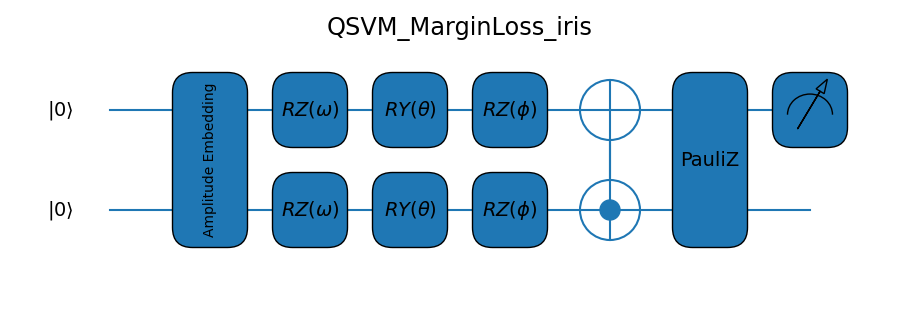

In [68]:
#circuit scheme
drawer = qml.drawer.MPLDrawer(n_wires=num_qubits, n_layers=num_layers)
drawer.label([r"$|0\rangle$",r"$|0\rangle$"] )
drawer.box_gate(layer=0, wires=[0, 1], text="Amplitude Embedding")
drawer.box_gate(layer=1, wires=[0], text=r"$RZ(\omega)$")
drawer.box_gate(layer=2, wires=[0], text=r"$RY(\theta)$")
drawer.box_gate(layer=3, wires=[0], text=r"$RZ(\phi)$")
drawer.CNOT(layer=4, wires=(0, 1))
drawer.box_gate(layer=1, wires=[1], text=r"$RZ(\omega)$")
drawer.box_gate(layer=2, wires=[1], text=r"$RY(\theta)$")
drawer.box_gate(layer=3, wires=[1], text=r"$RZ(\phi)$")
drawer.CNOT(layer=4, wires=(1, 0))
drawer.box_gate(layer=5, wires=[0,1], text =r"PauliZ" )
drawer.measure(layer=6, wires=0)
drawer.fig.suptitle('QSVM_MarginLoss_iris', fontsize='xx-large')

First X sample, original  : tensor([5.1000, 3.5000, 1.4000, 0.2000], dtype=torch.float64)
First X sample, normalized: tensor([0.8038, 0.5516, 0.2206, 0.0315], dtype=torch.float64)
Num params:  111
Iter:     1 | Cost: 0.3475123 | Acc train: 0.3214286 | Acc test: 0.3684211 | Iter time: 15.2823 
Iter:     2 | Cost: 0.2533208 | Acc train: 0.3214286 | Acc test: 0.3684211 | Iter time: 14.7950 
Iter:     3 | Cost: 0.2943570 | Acc train: 0.3214286 | Acc test: 0.3684211 | Iter time: 21.7818 
Iter:     4 | Cost: 0.3344342 | Acc train: 0.3214286 | Acc test: 0.3684211 | Iter time: 14.8767 
Iter:     5 | Cost: 0.2200930 | Acc train: 0.3214286 | Acc test: 0.3684211 | Iter time: 14.6817 
Iter:     6 | Cost: 0.2718903 | Acc train: 0.4910714 | Acc test: 0.5789474 | Iter time: 14.7500 
Iter:     7 | Cost: 0.2212835 | Acc train: 0.4910714 | Acc test: 0.4473684 | Iter time: 15.5906 
Iter:     8 | Cost: 0.1825542 | Acc train: 0.6785714 | Acc test: 0.6315789 | Iter time: 14.7789 
Iter:     9 | Cost: 0.10970

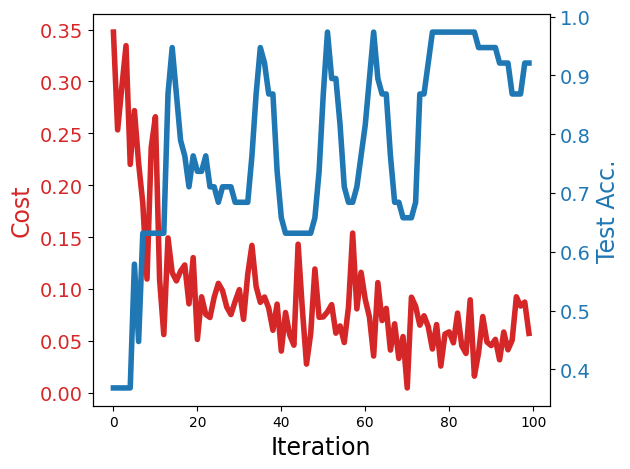

time elapsed for training & classification:  1510.3506820201874
CPU times: user 24min 46s, sys: 4.06 s, total: 24min 50s
Wall time: 25min 10s


In [24]:
%%time

features, target = load_and_process_data(X_iris,Y_iris)
start_t=time.time()
costs, train_acc, test_acc,itr_time,macro_a,macro_r,macro_p,mf1,error_s = training(features, target)
end_t=time.time()
elapsed= end_t - start_t

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

print("time elapsed for training & classification: ",elapsed)

In [25]:
df_iris = result(total_iterations,costs, train_acc, test_acc,itr_time,macro_a,macro_r,macro_p,mf1, error_s)
df_iris

,iterations,test error,train error,costs,training accuracy,testing accuracy,iteration time,macro accuracy,macro recall,macro precision,macro F1score,error_s
0,1,0.631579,0.678571,0.347512,0.321429,0.368421,15.282328,0.368421,0.333333,0.368421,0.179487,0.631579
1,2,0.631579,0.678571,0.253321,0.321429,0.368421,14.794950,0.368421,0.333333,0.368421,0.179487,0.631579
2,3,0.631579,0.678571,0.294357,0.321429,0.368421,21.781834,0.368421,0.333333,0.368421,0.179487,0.631579
3,4,0.631579,0.678571,0.334434,0.321429,0.368421,14.876710,0.368421,0.333333,0.368421,0.179487,0.631579
4,5,0.631579,0.678571,0.220093,0.321429,0.368421,14.681654,0.368421,0.333333,0.368421,0.179487,0.631579
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.131579,0.151786,0.050778,0.848214,0.868421,15.309248,0.868421,0.865079,0.884532,0.866871,0.131579
96,97,0.131579,0.133929,0.092555,0.866071,0.868421,14.927962,0.868421,0.865079,0.884532,0.866871,0.131579
97,98,0.131579,0.133929,0.083675,0.866071,0.868421,14.741821,0.868421,0.865079,0.884532,0.866871,0.131579
98,99,0.078947,0.080357,0.087491,0.919643,0.921053,14.664230,0.921053,0.920635,0.925253,0.922039,0.078947


In [78]:
max_row_index = df_iris["macro accuracy"].idxmax()

# Get the row with the maximum value
max_value = df_iris.loc[max_row_index]
max_value

iterations           52.000000
test error            0.026316
train error           0.062500
costs                 0.078097
training accuracy     0.937500
testing accuracy      0.973684
iteration time       14.509818
macro accuracy        0.973684
macro recall          0.976190
macro precision       0.974359
macro F1score         0.974321
error_s               0.026316
Name: 51, dtype: float64

### Wine quality dataset

In [26]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as np array)
X_w = np.array(wine_quality.data.features)
#y_w = wine_quality.data.targets
Y_w = wine_quality.data.original["color"]
lb = LabelBinarizer()
Y_w=np.array(lb.fit_transform(Y_w))

# variable information
print(wine_quality.variables)

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

In [27]:
X_w.shape

(6497, 11)

In [28]:
ClassIR(Y_w)

0.5

In [29]:
maxIR(Y_w)

3.063164477798624

### Parameters

In [69]:
num_classes = 2
margin = 0.15
feature_size = 12
batch_size = 10
lr_adam = 0.01
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
total_iterations = 2

dev = qml.device("default.qubit", wires=num_qubits)

'\nwill use amplitude embedding. This means that each possible amplitude (in the computational basis) will correspond to a single feature.\nWith 2 qubits (wires), there are 4 possible states, and as such, we can encode a feature vector of size 4.\n'

In [31]:
num_qubits

4

In [32]:
qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

Text(0.5, 0.98, 'QSVM_MarginLoss_Wine Quality')

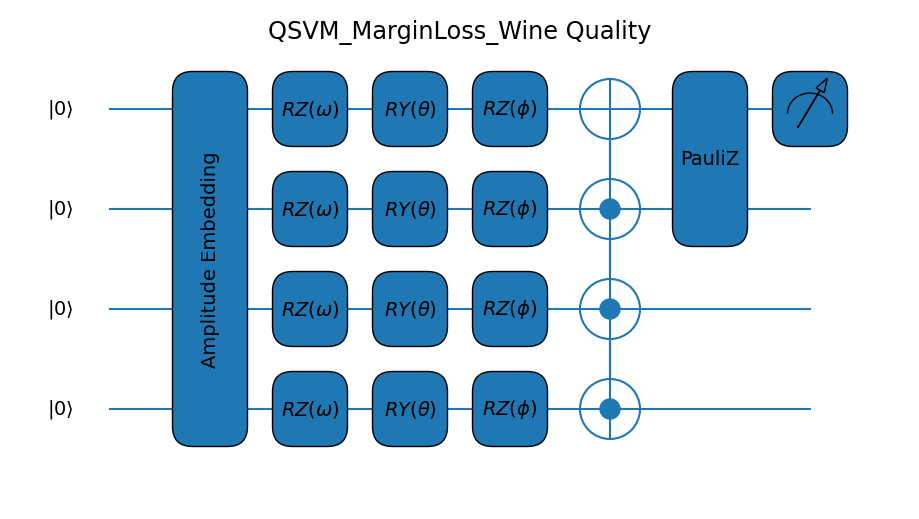

In [70]:
#circuit scheme
drawer = qml.drawer.MPLDrawer(n_wires=num_qubits, n_layers=num_layers)
drawer.label([r"$|0\rangle$",r"$|0\rangle$",r"$|0\rangle$",r"$|0\rangle$"])
drawer.box_gate(layer=0, wires=[0, 1, 2, 3], text="Amplitude Embedding")

drawer.box_gate(layer=1, wires=[0], text=r"$RZ(\omega)$")
drawer.box_gate(layer=2, wires=[0], text=r"$RY(\theta)$")
drawer.box_gate(layer=3, wires=[0], text=r"$RZ(\phi)$")
drawer.CNOT(layer=4, wires=(0, 1))

drawer.box_gate(layer=1, wires=[1], text=r"$RZ(\omega)$")
drawer.box_gate(layer=2, wires=[1], text=r"$RY(\theta)$")
drawer.box_gate(layer=3, wires=[1], text=r"$RZ(\phi)$")
drawer.CNOT(layer=4, wires=(1, 2))

drawer.box_gate(layer=1, wires=[2], text=r"$RZ(\omega)$")
drawer.box_gate(layer=2, wires=[2], text=r"$RY(\theta)$")
drawer.box_gate(layer=3, wires=[2], text=r"$RZ(\phi)$")
drawer.CNOT(layer=4, wires=(2, 3))

drawer.box_gate(layer=1, wires=[3], text=r"$RZ(\omega)$")
drawer.box_gate(layer=2, wires=[3], text=r"$RY(\theta)$")
drawer.box_gate(layer=3, wires=[3], text=r"$RZ(\phi)$")
drawer.CNOT(layer=4, wires=(3, 0))

drawer.box_gate(layer=5, wires=[0,1], text =r"PauliZ" )
drawer.measure(layer=6, wires=0)
drawer.fig.suptitle('QSVM_MarginLoss_Wine Quality', fontsize='xx-large')

#### smaller sample size run

In [34]:
total_iterations = 10
random_index = np.random.choice(X_w.shape[0], size = 1000, replace = False)
X_ws=X_w[random_index]
Y_ws=Y_w[random_index]

In [35]:
ClassIR(Y_ws)

0.5

In [36]:
maxIR(Y_ws)

2.802281368821293

First X sample, original  : tensor([7.4000e+00, 1.9000e-01, 4.9000e-01, 9.3000e+00, 3.0000e-02, 2.6000e+01,
        1.3200e+02, 9.9400e-01, 2.9900e+00, 3.2000e-01, 1.1000e+01],
       dtype=torch.float64)
First X sample, normalized: tensor([5.4594e-02, 1.4017e-03, 3.6150e-03, 6.8612e-02, 2.2133e-04, 1.9182e-01,
        9.7384e-01, 7.3333e-03, 2.2059e-02, 2.3608e-03, 8.1154e-02],
       dtype=torch.float64)
Num params:  219
Iter:     1 | Cost: 0.1448031 | Acc train: 0.7440000 | Acc test: 0.7160000 | Iter time: 117.2280 
Iter:     2 | Cost: 0.1582215 | Acc train: 0.7440000 | Acc test: 0.7160000 | Iter time: 119.0789 
Iter:     3 | Cost: 0.0115011 | Acc train: 0.7440000 | Acc test: 0.7160000 | Iter time: 120.1588 
Iter:     4 | Cost: 0.1162152 | Acc train: 0.7440000 | Acc test: 0.7160000 | Iter time: 119.8396 
Iter:     5 | Cost: 0.1198125 | Acc train: 0.7440000 | Acc test: 0.7160000 | Iter time: 118.5537 
Iter:     6 | Cost: 0.1936979 | Acc train: 0.7440000 | Acc test: 0.7160000 | Iter t

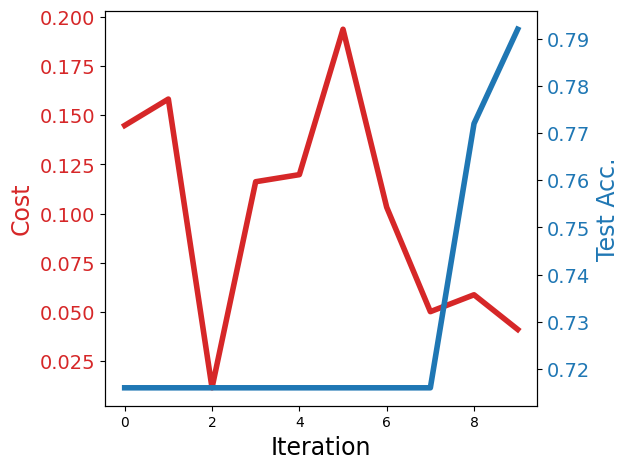

time elapsed for training & classification:  1199.9291746616364
CPU times: user 19min 44s, sys: 3.25 s, total: 19min 47s
Wall time: 20min


In [37]:
%%time
# We now run our training algorithm and plot the results. Note that

features, target = load_and_process_data(X_ws,Y_ws)
start_t=time.time()
costs, train_acc, test_acc,itr_time,macro_a,macro_r,macro_p,mf1,error_s = training(features, target)
end_t=time.time()
elapsed= end_t - start_t

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

print("time elapsed for training & classification: ",elapsed)

In [38]:
df_w_s1 = result(total_iterations,costs, train_acc, test_acc,itr_time,macro_a,macro_r,macro_p,mf1,error_s)
df_w_s1

,iterations,test error,train error,costs,training accuracy,testing accuracy,iteration time,macro accuracy,macro recall,macro precision,macro F1score,error_s
0,1,0.284,0.256000,0.144803,0.744000,0.716,117.228009,0.716,0.500000,0.716000,0.417249,0.284
1,2,0.284,0.256000,0.158221,0.744000,0.716,119.078932,0.716,0.500000,0.716000,0.417249,0.284
2,3,0.284,0.256000,0.011501,0.744000,0.716,120.158758,0.716,0.500000,0.716000,0.417249,0.284
3,4,0.284,0.256000,0.116215,0.744000,0.716,119.839598,0.716,0.500000,0.716000,0.417249,0.284
4,5,0.284,0.256000,0.119813,0.744000,0.716,118.553686,0.716,0.500000,0.716000,0.417249,0.284
5,6,0.284,0.256000,0.193698,0.744000,0.716,119.597266,0.716,0.500000,0.716000,0.417249,0.284
6,7,0.284,0.256000,0.103252,0.744000,0.716,120.919606,0.716,0.500000,0.716000,0.417249,0.284
7,8,0.284,0.256000,0.050193,0.744000,0.716,123.741785,0.716,0.500000,0.716000,0.417249,0.284
8,9,0.228,0.224000,0.058773,0.776000,0.772,121.293389,0.772,0.598592,0.879237,0.596031,0.228
9,10,0.208,0.206667,0.041152,0.793333,0.792,119.475114,0.792,0.633803,0.887446,0.647696,0.208


In [79]:
max_row_index = df_w_s1["macro accuracy"].idxmax()

# Get the row with the maximum value
max_value = df_w_s1.loc[max_row_index]
max_value

iterations            10.000000
test error             0.208000
train error            0.206667
costs                  0.041152
training accuracy      0.793333
testing accuracy       0.792000
iteration time       119.475114
macro accuracy         0.792000
macro recall           0.633803
macro precision        0.887446
macro F1score          0.647696
error_s                0.208000
Name: 9, dtype: float64

### MNIST

In [3]:
# Load MNIST dataset
mnist = fetch_openml("mnist_784")

# Extract features and labels as NumPy arrays
X_m, y_m = mnist.data.to_numpy(), mnist.target.to_numpy()

C:\Users\Skalvis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### preparing MNIST

In [40]:
#overall 70k observations
ClassIR(y_m)

0.1

In [41]:
#overall 70k observations
maxIR(y_m)

1.2477427530492635

In [16]:
#function fo
import seaborn as sns
import pandas as pd

# function to help plot the 2-D dataset
def plot2d(X, Y, c1, c2, N):
    lbl1 = f'transformed x {c1}'
    lbl2 = f'transformed x {c2}'
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})

### Parameters

In [71]:
num_classes = 10
margin = 0.15
feature_size = 2
batch_size = 10
lr_adam = 0.01
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
total_iterations = 10

dev = qml.device("default.qubit", wires=num_qubits)

In [44]:
int(np.ceil(np.log2(feature_size)))

1

In [45]:
qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

#### Smaller sample size shuffled

In [12]:
random_index_m = np.random.choice(X_m.shape[0], size = 1000, replace = False)
X_ms=X_m[random_index_m]
Y_ms=y_m[random_index_m]

In [13]:
Y_ms=Y_ms.astype(int)
print(Y_ms.shape)
Y_ms

(1000,)


array([6, 6, 3, 5, 0, 5, 4, 3, 3, 0, 4, 1, 7, 7, 7, 5, 6, 4, 2, 0, 2, 8,
       8, 2, 5, 5, 7, 6, 3, 1, 9, 3, 1, 1, 3, 9, 3, 9, 8, 8, 4, 7, 7, 9,
       3, 7, 9, 8, 6, 0, 2, 6, 6, 8, 7, 8, 9, 3, 3, 1, 9, 5, 0, 0, 8, 9,
       1, 9, 6, 0, 0, 0, 7, 7, 1, 3, 1, 7, 4, 2, 3, 4, 5, 7, 2, 9, 3, 5,
       1, 7, 1, 2, 1, 3, 7, 2, 5, 7, 2, 2, 6, 6, 7, 5, 7, 5, 8, 6, 7, 5,
       3, 5, 4, 1, 0, 7, 8, 1, 5, 1, 5, 7, 9, 3, 3, 2, 9, 2, 4, 4, 2, 6,
       9, 6, 4, 8, 3, 6, 0, 6, 2, 6, 8, 9, 8, 3, 1, 3, 3, 7, 1, 5, 8, 2,
       3, 6, 2, 6, 6, 9, 1, 2, 4, 2, 6, 0, 8, 0, 5, 8, 6, 2, 8, 0, 9, 7,
       8, 9, 8, 4, 1, 1, 4, 9, 8, 1, 2, 2, 3, 2, 0, 3, 6, 1, 2, 6, 4, 7,
       5, 0, 0, 2, 4, 5, 5, 2, 7, 9, 1, 2, 8, 9, 0, 1, 8, 7, 3, 8, 4, 5,
       2, 9, 3, 3, 7, 6, 2, 5, 3, 4, 0, 0, 8, 6, 5, 9, 4, 2, 7, 6, 3, 3,
       0, 0, 0, 9, 9, 5, 1, 6, 6, 5, 6, 9, 0, 5, 7, 1, 8, 0, 2, 3, 4, 0,
       9, 5, 0, 2, 5, 0, 4, 6, 1, 3, 9, 3, 0, 1, 6, 3, 7, 8, 2, 0, 0, 6,
       3, 9, 4, 2, 2, 9, 7, 0, 9, 0, 3, 5, 9, 2, 8,

In [48]:
#actual
ClassIR(Y_ms)

0.1

In [49]:
#actual
maxIR(Y_ms)

1.3953488372093024

In [14]:
%%time
# Using SVD to bring down the dimension to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(X_ms)

# Further using t-SNE to bring the dimension down to 2
tsne = TSNE(n_components=2)
X_ms_pf = tsne.fit_transform(X_SVD)

Wall time: 4.24 s


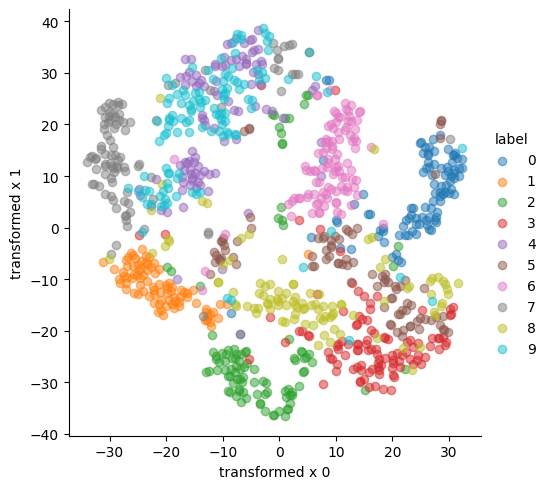

In [17]:
plot2d(X_ms_pf, Y_ms, 0, 1, N=1000)

Text(0.5, 0.98, 'QSVM_MarginLoss_MNIST')

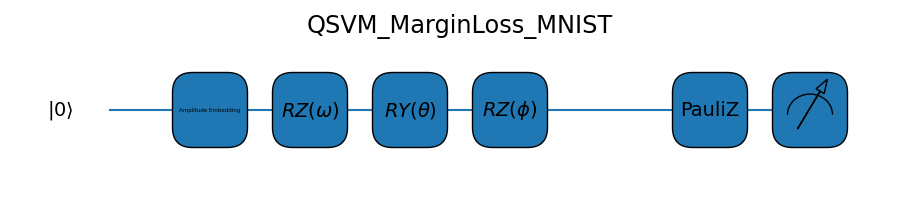

In [73]:
#circuit scheme
drawer = qml.drawer.MPLDrawer(n_wires=num_qubits, n_layers=num_layers)
drawer.label([r"$|0\rangle$"] )
drawer.box_gate(layer=0, wires=[0], text="Amplitude Embedding")

drawer.box_gate(layer=1, wires=[0], text=r"$RZ(\omega)$")
drawer.box_gate(layer=2, wires=[0], text=r"$RY(\theta)$")
drawer.box_gate(layer=3, wires=[0], text=r"$RZ(\phi)$")

drawer.box_gate(layer=5, wires=[0], text =r"PauliZ" )
drawer.measure(layer=6, wires=0)
drawer.fig.suptitle('QSVM_MarginLoss_MNIST', fontsize='xx-large')

First X sample, original  : tensor([-0.6433, 29.1591])
First X sample, normalized: tensor([-0.0221,  0.9998])
Num params:  57
Iter:     1 | Cost: 1.8976996 | Acc train: 0.0973333 | Acc test: 0.0720000 | Iter time: 153.1243 
Iter:     2 | Cost: 1.8550020 | Acc train: 0.0826667 | Acc test: 0.0720000 | Iter time: 154.9628 
Iter:     3 | Cost: 1.7289864 | Acc train: 0.0866667 | Acc test: 0.0720000 | Iter time: 156.9039 
Iter:     4 | Cost: 1.4239271 | Acc train: 0.1400000 | Acc test: 0.1320000 | Iter time: 167.6174 
Iter:     5 | Cost: 1.2122453 | Acc train: 0.2053333 | Acc test: 0.1640000 | Iter time: 167.8163 
Iter:     6 | Cost: 1.0130713 | Acc train: 0.2000000 | Acc test: 0.1600000 | Iter time: 172.7547 
Iter:     7 | Cost: 1.1407402 | Acc train: 0.1973333 | Acc test: 0.1600000 | Iter time: 160.5154 
Iter:     8 | Cost: 0.5143324 | Acc train: 0.1893333 | Acc test: 0.1520000 | Iter time: 159.7497 
Iter:     9 | Cost: 1.1185344 | Acc train: 0.1893333 | Acc test: 0.1520000 | Iter time: 16

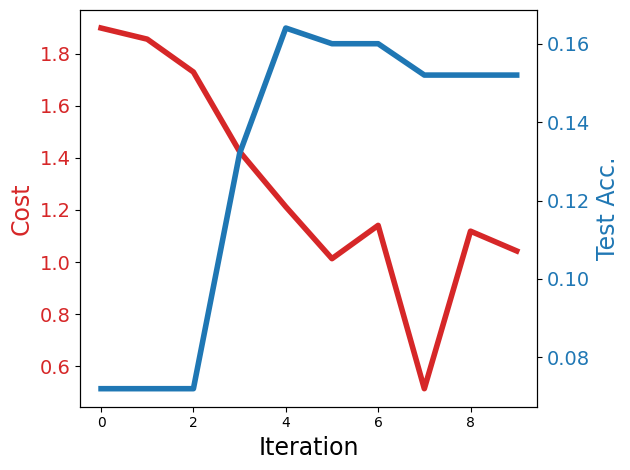

time elapsed for training & classification:  1624.0679531097412
CPU times: user 26min 31s, sys: 4.83 s, total: 26min 36s
Wall time: 27min 4s


In [53]:
%%time
# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required

features, target = load_and_process_data(X_ms_pf,Y_ms)
start_t=time.time()
costs, train_acc, test_acc,itr_time,macro_a,macro_r,macro_p,mf1,error_s = training(features, target)
end_t=time.time()
elapsed= end_t - start_t

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

print("time elapsed for training & classification: ",elapsed)

In [54]:
df_m_s1 = result(total_iterations,costs, train_acc, test_acc,itr_time,macro_a,macro_r,macro_p,mf1,error_s)
df_m_s1

,iterations,test error,train error,costs,training accuracy,testing accuracy,iteration time,macro accuracy,macro recall,macro precision,macro F1score,error_s
0,1,0.928,0.902667,1.897700,0.097333,0.072,153.124281,0.072,0.076580,0.067016,0.033761,0.928
1,2,0.928,0.917333,1.855002,0.082667,0.072,154.962845,0.072,0.076232,0.047950,0.028999,0.928
2,3,0.928,0.913333,1.728986,0.086667,0.072,156.903893,0.072,0.076580,0.068525,0.034577,0.928
3,4,0.868,0.860000,1.423927,0.140000,0.132,167.617440,0.132,0.146085,0.089112,0.055444,0.868
4,5,0.836,0.794667,1.212245,0.205333,0.164,167.816278,0.164,0.186128,0.115818,0.058506,0.836
5,6,0.840,0.800000,1.013071,0.200000,0.160,172.754741,0.160,0.181781,0.114554,0.057732,0.840
6,7,0.840,0.802667,1.140740,0.197333,0.160,160.515450,0.160,0.181781,0.115295,0.058025,0.840
7,8,0.848,0.810667,0.514332,0.189333,0.152,159.749716,0.152,0.173085,0.111162,0.055772,0.848
8,9,0.848,0.810667,1.118534,0.189333,0.152,162.503058,0.152,0.173085,0.111357,0.055834,0.848
9,10,0.848,0.810667,1.042668,0.189333,0.152,168.073076,0.152,0.173085,0.112575,0.056321,0.848


In [80]:
max_row_index = df_m_s1["macro accuracy"].idxmax()

# Get the row with the maximum value
max_value = df_m_s1.loc[max_row_index]
max_value

iterations             5.000000
test error             0.836000
train error            0.794667
costs                  1.212245
training accuracy      0.205333
testing accuracy       0.164000
iteration time       167.816278
macro accuracy         0.164000
macro recall           0.186128
macro precision        0.115818
macro F1score          0.058506
error_s                0.836000
Name: 4, dtype: float64

### Circle data set

In [55]:
# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):

    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def plot_data(x, y, fig=None, ax=None):

    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


In [56]:
# Generate training and test data
num_training = 1500
num_test = 500

Xdata, ydata = circle(num_training)
Xtest, y_test = circle(num_test)

First X sample, original  : tensor([ 0.5062, -0.6077], dtype=torch.float64)
First X sample, normalized: tensor([ 0.6401, -0.7683], dtype=torch.float64)
First X sample, original  : tensor([0.3078, 0.8499], dtype=torch.float64)
First X sample, normalized: tensor([0.3405, 0.9402], dtype=torch.float64)


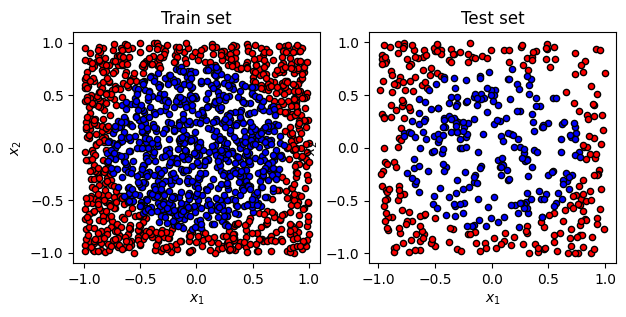

In [57]:
X_train_ploting, Y_train_ploting = load_and_process_data(Xdata,ydata)
X_test_ploting, Y_test_ploting = load_and_process_data(Xtest,y_test)
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
plot_data(Xdata, ydata, fig, axes[0])
plot_data(X_test_ploting, Y_test_ploting, fig, axes[1])
axes[0].set_title("Train set")
axes[1].set_title("Test set")
plt.show()

In [58]:
ClassIR(ydata)

0.5

In [59]:
maxIR(ydata)

1.027027027027027

### Parameters

In [74]:
num_classes = 2
margin = 0.15
feature_size = 2
batch_size = 10
lr_adam = 0.01
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
total_iterations = 50

dev = qml.device("default.qubit", wires=num_qubits)

In [61]:
num_qubits

1

In [62]:
qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

Text(0.5, 0.98, 'QSVM_MarginLoss_Circle')

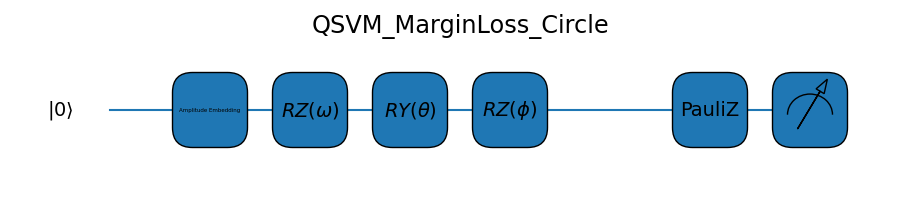

In [76]:
#circuit scheme
drawer = qml.drawer.MPLDrawer(n_wires=num_qubits, n_layers=num_layers)
drawer.label([r"$|0\rangle$"] )
drawer.box_gate(layer=0, wires=[0], text="Amplitude Embedding")

drawer.box_gate(layer=1, wires=[0], text=r"$RZ(\omega)$")
drawer.box_gate(layer=2, wires=[0], text=r"$RY(\theta)$")
drawer.box_gate(layer=3, wires=[0], text=r"$RZ(\phi)$")
#drawer.CNOT(layer=4, wires=(0, 1))

drawer.box_gate(layer=5, wires=[0], text =r"PauliZ" )
drawer.measure(layer=6, wires=0)
drawer.fig.suptitle('QSVM_MarginLoss_Circle', fontsize='xx-large')

### circles training

First X sample, original  : tensor([ 0.5062, -0.6077], dtype=torch.float64)
First X sample, normalized: tensor([ 0.6401, -0.7683], dtype=torch.float64)
Num params:  57
Iter:     1 | Cost: 0.0949604 | Acc train: 0.5075556 | Acc test: 0.5146667 | Iter time: 47.1043 
Iter:     2 | Cost: 0.1754090 | Acc train: 0.5075556 | Acc test: 0.5040000 | Iter time: 46.0334 
Iter:     3 | Cost: 0.0996758 | Acc train: 0.5057778 | Acc test: 0.4906667 | Iter time: 45.4749 
Iter:     4 | Cost: 0.2002810 | Acc train: 0.4942222 | Acc test: 0.4960000 | Iter time: 46.1950 
Iter:     5 | Cost: 0.1335106 | Acc train: 0.4924444 | Acc test: 0.4693333 | Iter time: 44.5253 
Iter:     6 | Cost: 0.1498699 | Acc train: 0.4613333 | Acc test: 0.4666667 | Iter time: 45.8179 
Iter:     7 | Cost: 0.2008023 | Acc train: 0.4897778 | Acc test: 0.5040000 | Iter time: 44.8061 
Iter:     8 | Cost: 0.1326585 | Acc train: 0.4897778 | Acc test: 0.5040000 | Iter time: 46.0776 
Iter:     9 | Cost: 0.1880518 | Acc train: 0.4897778 | A

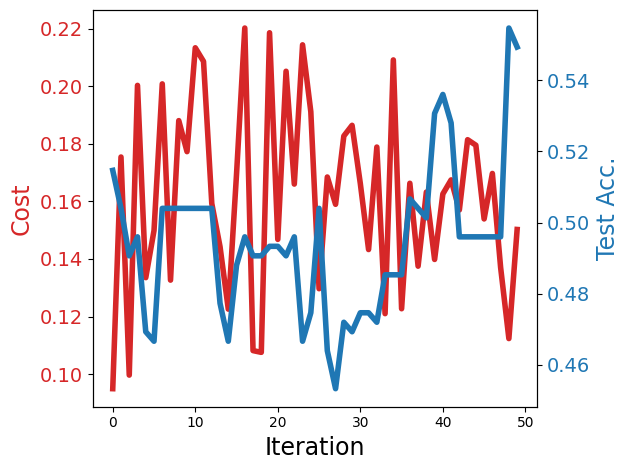

time elapsed for training & classification:  2313.796950340271
CPU times: user 38min 7s, sys: 5.96 s, total: 38min 13s
Wall time: 38min 34s


In [64]:
%%time

features, target = load_and_process_data(Xdata,ydata)
start_t=time.time()
costs, train_acc, test_acc,itr_time,macro_a,macro_r,macro_p,mf1,error_s = training(features, target)
end_t=time.time()
elapsed= end_t - start_t

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

print("time elapsed for training & classification: ",elapsed)

In [65]:
df_c = result(total_iterations,costs, train_acc, test_acc,itr_time,macro_a,macro_r,macro_p,mf1,error_s)
df_c

,iterations,test error,train error,costs,training accuracy,testing accuracy,iteration time,macro accuracy,macro recall,macro precision,macro F1score,error_s
0,1,0.485333,0.492444,0.094960,0.507556,0.514667,47.104338,0.514667,0.514678,0.514677,0.514663,0.485333
1,2,0.496000,0.492444,0.175409,0.507556,0.504000,46.033383,0.504000,0.503926,0.503927,0.503912,0.496000
2,3,0.509333,0.494222,0.099676,0.505778,0.490667,45.474943,0.490667,0.490485,0.490466,0.490304,0.509333
3,4,0.504000,0.505778,0.200281,0.494222,0.496000,46.195010,0.496000,0.495520,0.495455,0.493927,0.504000
4,5,0.530667,0.507556,0.133511,0.492444,0.469333,44.525291,0.469333,0.468510,0.467126,0.463226,0.530667
5,6,0.533333,0.538667,0.149870,0.461333,0.466667,45.817865,0.466667,0.464627,0.452239,0.428423,0.533333
6,7,0.496000,0.510222,0.200802,0.489778,0.504000,44.806067,0.504000,0.500000,0.504000,0.335106,0.496000
7,8,0.496000,0.510222,0.132658,0.489778,0.504000,46.077638,0.504000,0.500000,0.504000,0.335106,0.496000
8,9,0.496000,0.510222,0.188052,0.489778,0.504000,45.345259,0.504000,0.500000,0.504000,0.335106,0.496000
9,10,0.496000,0.510222,0.177271,0.489778,0.504000,46.486037,0.504000,0.500000,0.504000,0.335106,0.496000


In [81]:
max_row_index = df_c["macro accuracy"].idxmax()

# Get the row with the maximum value
max_value = df_c.loc[max_row_index]
max_value

iterations           49.000000
test error            0.445333
train error           0.433778
costs                 0.112366
training accuracy     0.566222
testing accuracy      0.554667
iteration time       46.503348
macro accuracy        0.554667
macro recall          0.556196
macro precision       0.565754
macro F1score         0.538589
error_s               0.445333
Name: 48, dtype: float64